#### Import necessary libraries

In [1]:
import scanpy as sc
import hdf5plugin
import numpy as np
import pandas as pd
import decoupler as dc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Initialize utility functions

In [2]:
def create_marker_dict(df_cellmarker, cell_name="cell_name", marker="Symbol"):
    cell_markers = {}
    for i in list(set(df_cellmarker[cell_name].values.tolist())):
        genes = df_cellmarker[df_cellmarker[cell_name]==i][marker].values.tolist()
        cell_markers[i] = genes
    return cell_markers


def create_melted_df(score_df, ctype_lst):
    # Step 1: Creating separate DataFrames for each cluster
    cluster_dfs = [score_df[score_df['cluster'] == str(i)] for i in range(len(score_df["cluster"].value_counts()))]

    # Step 2: Adding a 'dataset' column
    dfs = [df.assign(dataset=f'dataset_{i}') for i, df in enumerate(cluster_dfs)]

    # Checking the assignment of the 'dataset' column

    # Step 3: Concatenating DataFrames into one
    final_df = pd.concat(dfs, ignore_index=True)

    # Confirming that the 'dataset' column is present in the concatenated DataFrame


    # Step 4: Melting the DataFrame for seaborn plotting
    final_df_melted = final_df.melt(id_vars=['dataset', 'cluster'], 
                                    value_vars=ctype_lst,
                                    var_name='cell_type',
                                    value_name='score')

    # Ensuring the melted DataFrame looks as expected
    return final_df_melted


def cluster_vln_plot(melted_df):
    # Plotting
    plt.figure(figsize=(16, 6))
    ax = sns.violinplot(x='cluster', y='score', hue='cell_type', data=melted_df, 
                   inner="quartile", palette="muted", scale="count")

    # Ensuring gridlines are below plot elements
    ax.set_axisbelow(True)

    # Adding gridlines
    ax.yaxis.grid(True, color="gainsboro", linestyle="dashed")  # Horizontal gridlines

    # Compute midpoints between x-tick labels for grid placement
    xticks = ax.get_xticks()
    midpoints = (xticks[:-1] + xticks[1:]) / 2

    # Add vertical gridlines at midpoints
    ax.vlines(midpoints, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='lightgray', linestyles='solid', linewidth=0.5)

    # Customizing other plot elements
    # ax.set_facecolor("lightgray")
    plt.gca().set_facecolor("whitesmoke")

    plt.title(f'Violin plots of cell-type ORA scores across leiden clusters')
    plt.ylabel('ORA score')
    plt.xlabel('Leiden cluster')

    plt.legend(title='Cell Type', bbox_to_anchor=(1.01, 1), loc='upper left')

    legend = ax.get_legend()


# Save the currently active figure with high DPI
    plt.savefig('./ora_violins_600dpi.png', 
                dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
    
    
#     plt.tight_layout()
    plt.show()
    
    

def cluster_vln_plot2(melted_df, specific_cluster):
    # Filter the DataFrame for the specific cluster
    filtered_df = melted_df[melted_df['cluster'] == specific_cluster]

    # Initialize the matplotlib figure
    plt.figure(figsize=(8, 6))

    # Create the violin plot
    ax = sns.violinplot(x='cell_type', y='score', data=filtered_df, inner="quartile", palette="muted", scale="width")

    # Customize the axes and grid
    ax.set_xlabel('Cell Type')
    ax.set_ylabel('ORA score')
    ax.grid(axis='y', linestyle='--', color='grey', linewidth=0.7, alpha=0.7)

    # Set the title of the plot
    plt.title(f'Violin plot of cell-type ORA scores for cluster {specific_cluster}')

    # Adjust the plot to ensure everything fits well
    plt.tight_layout()

    # Show the plot
    plt.show()

#### Parameters

In [3]:
CLUSTER_RESOLUTION = 0.25

#### Paths for marker genes, integrated anndata object and final anndata object (cell-type annotation result)

In [4]:
H5AD_PATH = "./data/6.H5AD_integrated/scVI_integration_v1.h5ad"
MARKER_GENES = "./data/9.Marker_genes/brain_markers.csv"

#### Read integrated anndata object from disk

In [5]:
adata = sc.read_h5ad(H5AD_PATH)
adata

AnnData object with n_obs × n_vars = 12626 × 19965
    obs: 'batch', 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'doublet', 'batch_num', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'condition_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

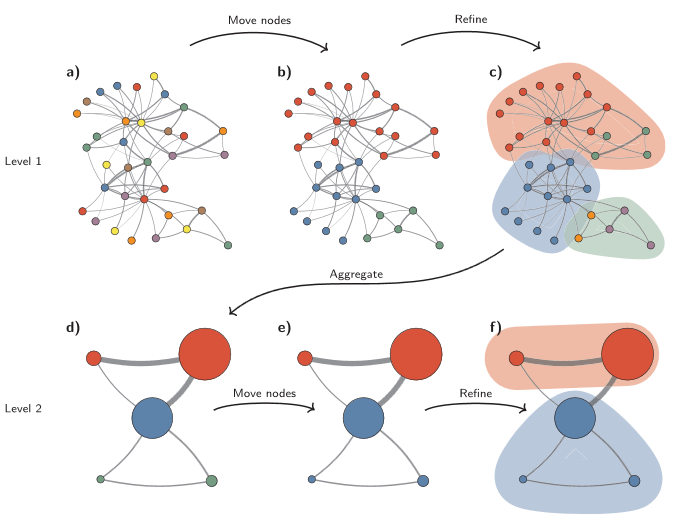

In [6]:
sc.tl.leiden(adata, resolution = CLUSTER_RESOLUTION, key_added = "leiden")

#### Read list of markers and cell types into a pandas dataframe

In [7]:
cell_markers = pd.read_csv(MARKER_GENES)
cell_markers = cell_markers.drop_duplicates()
cell_markers

,cell_name,Symbol
0,Pericyte,MCAM
1,Pericyte,NGFR
2,Pericyte,PECAM1
3,Pericyte,PTPRC
4,Pericyte,CSPG4
...,...,...
724,Oligodendrocyte,PDGFRA
725,Oligodendrocyte,QKI
726,Oligodendrocyte,PCDH9
727,Oligodendrocyte precursor cell,SOX6


In [ ]:
sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc="on data",
           legend_fontsize=12, legend_fontoutline=2,frameon=False, title='Leiden Clustering', show=False)

#Save the currently active figure with high DPI
plt.savefig('./figures/umap_leiden_025.png', dpi=600, bbox_inches='tight')

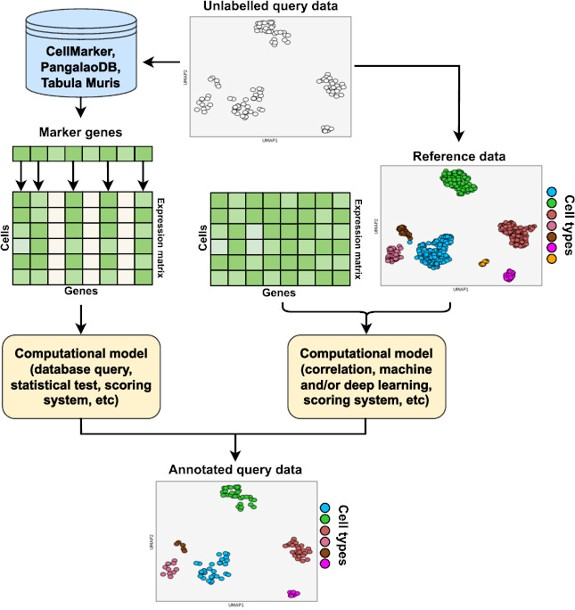

#### Enrichment with Over Representation Analysis (ORA)

In [8]:
dc.run_ora(
    mat=adata,
    net=cell_markers,
    source='cell_name',
    target='Symbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

Running ora on mat with 12626 samples and 19965 targets for 7 sources.


100%|█████████████████████████████████████████████████████████████████████████████████████| 12626/12626 [00:09<00:00, 1315.38it/s]


#### The obtained scores (-log10(p-value))(ora_estimate) and p-values (ora_pvals) are stored in the .obsm key

In [9]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 12626 × 7
    obs: 'batch', 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'doublet', 'batch_num', '_scvi_batch', '_scvi_labels', 'leiden'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'condition_colors', 'log1p', 'neighbors', 'umap', 'leiden'
    obsm: 'X_scVI', 'X_umap', 'ora_estimate', 'ora_pvals'

#### Create cell-type list and ORA-score dataframe

In [10]:
score_df = adata.obsm['ora_estimate']
ctype_lst = list(score_df.columns)
score_df["cluster"] = adata.obs["leiden"]
ctype_lst

['Astrocyte',
 'Excitatory neuron',
 'Inhibitory neuron',
 'Microglial cell',
 'Oligodendrocyte',
 'Oligodendrocyte precursor cell',
 'Pericyte']

In [11]:
melted_df = create_melted_df(score_df, ctype_lst)
melted_df

,dataset,cluster,cell_type,score
0,dataset_0,0,Astrocyte,0.117147
1,dataset_0,0,Astrocyte,0.569050
2,dataset_0,0,Astrocyte,0.416307
3,dataset_0,0,Astrocyte,0.749056
4,dataset_0,0,Astrocyte,0.290682
...,...,...,...,...
88377,dataset_18,18,Pericyte,2.511694
88378,dataset_18,18,Pericyte,1.612632
88379,dataset_18,18,Pericyte,2.511694
88380,dataset_18,18,Pericyte,-0.000000


#### Create ORA-score violin plots for all leiden clusters and cell-types

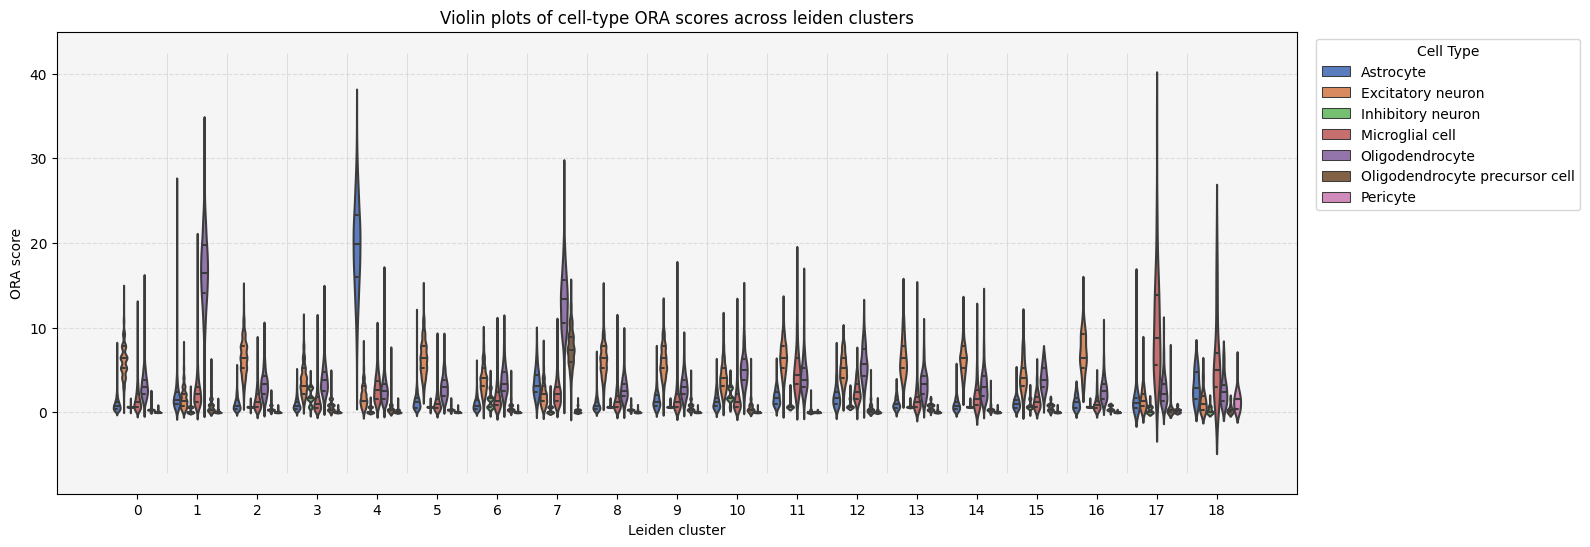

In [12]:
cluster_vln_plot(melted_df)

#### Visualize the obtained ORA scores

In [13]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,Excitatory neuron,31.634263,1.831964,3.727979e-202,2.609585e-201
1,0,rest,Microglial cell,-10.888481,-0.476645,2.502516e-27,2.502516e-27
2,0,rest,Inhibitory neuron,-11.307438,-0.153236,4.223689e-29,4.927637e-29
3,0,rest,Pericyte,-15.702684,-0.057904,7.074725e-54,9.904614e-54
4,0,rest,Oligodendrocyte precursor cell,-19.943452,-0.712019,1.820961e-83,3.186682e-83
...,...,...,...,...,...,...,...
128,9,rest,Microglial cell,-3.079646,-0.315544,2.124609e-03,2.478710e-03
129,9,rest,Inhibitory neuron,-3.911467,-0.111873,1.019033e-04,1.426646e-04
130,9,rest,Pericyte,-3.986709,-0.033013,7.286434e-05,1.275126e-04
131,9,rest,Astrocyte,-5.724663,-1.260646,1.640186e-08,3.827100e-08


In [14]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['Excitatory neuron', 'Microglial cell', 'Inhibitory neuron'],
 '1': ['Oligodendrocyte', 'Microglial cell', 'Pericyte'],
 '10': ['Inhibitory neuron', 'Oligodendrocyte', 'Microglial cell'],
 '11': ['Microglial cell', 'Excitatory neuron', 'Inhibitory neuron'],
 '12': ['Microglial cell', 'Excitatory neuron', 'Inhibitory neuron'],
 '13': ['Excitatory neuron', 'Pericyte', 'Oligodendrocyte precursor cell'],
 '14': ['Excitatory neuron', 'Microglial cell', 'Pericyte'],
 '15': ['Inhibitory neuron',
  'Excitatory neuron',
  'Oligodendrocyte precursor cell'],
 '16': ['Excitatory neuron', 'Inhibitory neuron', 'Pericyte'],
 '17': ['Microglial cell', 'Pericyte', 'Astrocyte'],
 '18': ['Pericyte', 'Microglial cell', 'Astrocyte'],
 '2': ['Excitatory neuron', 'Pericyte', 'Microglial cell'],
 '3': ['Inhibitory neuron', 'Pericyte', 'Oligodendrocyte precursor cell'],
 '4': ['Astrocyte', 'Microglial cell', 'Pericyte'],
 '5': ['Excitatory neuron', 'Inhibitory neuron', 'Pericyte'],
 '6': ['Inhibitory ne

In [15]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'Excitatory neuron',
 '1': 'Oligodendrocyte',
 '10': 'Inhibitory neuron',
 '11': 'Microglial cell',
 '12': 'Microglial cell',
 '13': 'Excitatory neuron',
 '14': 'Excitatory neuron',
 '15': 'Inhibitory neuron',
 '16': 'Excitatory neuron',
 '17': 'Microglial cell',
 '18': 'Pericyte',
 '2': 'Excitatory neuron',
 '3': 'Inhibitory neuron',
 '4': 'Astrocyte',
 '5': 'Excitatory neuron',
 '6': 'Inhibitory neuron',
 '7': 'Oligodendrocyte precursor cell',
 '8': 'Excitatory neuron',
 '9': 'Excitatory neuron'}

In [16]:
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

In [17]:
ctype_dict = {'Oligodendrocyte precursor cell': "OPC"}

In [18]:
adata.obs['cell_type'] = adata.obs['cell_type'].replace(ctype_dict)

In [ ]:
sc.pl.umap(adata, 
           color='cell_type', 
           add_outline=True, 
#            legend_loc="on data",
           legend_fontsize=12, 
           legend_fontoutline=2,
           frameon=False, 
           title='Cell-types (decoupleR Annotation)', 
           show=False)

#Save the currently active figure with high DPI
plt.savefig('./figures/umap_types_decoupler.png', dpi=600, bbox_inches='tight')

In [19]:
cell_marker4disp = pd.read_csv("./data/9.Marker_genes/brain_markers4display.csv")
cell_marker4disp

,cell_name,Symbol
0,Astrocyte,GFAP
1,Astrocyte,FGFR3
2,Astrocyte,SLC4A4
3,Astrocyte,SLC14A1
4,Astrocyte,NFIA
...,...,...
91,Excitatory neuron,NCAM1
92,Excitatory neuron,ATP1A3
93,Oligodendrocyte precursor cell,DSCAM
94,Oligodendrocyte precursor cell,SOX6


In [20]:
cell_marker4disp_dic = create_marker_dict(cell_marker4disp)
cell_marker4disp_dic

{'Pericyte': ['MCAM',
  'NGFR',
  'PECAM1',
  'PTPRC',
  'CSPG4',
  'CSPG4',
  'ABCC9',
  'RGS5',
  'PDGFRB',
  'FOXF2',
  'KCNJ8',
  'ANPEP',
  'MCAM',
  'DCN',
  'BMP4'],
 'Astrocyte': ['GFAP',
  'FGFR3',
  'SLC4A4',
  'SLC14A1',
  'NFIA',
  'GABRB1',
  'CLU',
  'NTRK2',
  'SPARCL1',
  'SLC1A2',
  'DTNA',
  'GLUL',
  'SLC1A3',
  'PTGDS',
  'RYR3',
  'ATP1A2'],
 'Inhibitory neuron': ['GAD1', 'DLX5', 'DLX2', 'GAD2', 'SYT1'],
 'Oligodendrocyte precursor cell': ['PDGFRA',
  'LHFPL3',
  'PCDH15',
  'MEGF11',
  'OLIG1',
  'APOD',
  'SOX10',
  'PMP2',
  'OLIG2',
  'VCAN',
  'DSCAM',
  'SOX6',
  'CSPG4'],
 'Oligodendrocyte': ['RTN4',
  'PLP1',
  'MBP',
  'GSN',
  'MOBP',
  'CLDN11',
  'TCF12',
  'TMEFF2',
  'ZEB2',
  'TF',
  'PTGDS',
  'CNDP1',
  'CNTNAP2',
  'QKI',
  'PCDH9'],
 'Microglial cell': ['SLC1A3',
  'APBB1IP',
  'CD74',
  'DOCK8',
  'GRIA2',
  'ATP1A3',
  'PKM',
  'PGAM1',
  'GNAS',
  'KCNMA1',
  'PEBP1',
  'ALDOA',
  'KIF1A',
  'FTL',
  'SORL1',
  'FKBP5'],
 'Excitatory neuron': 

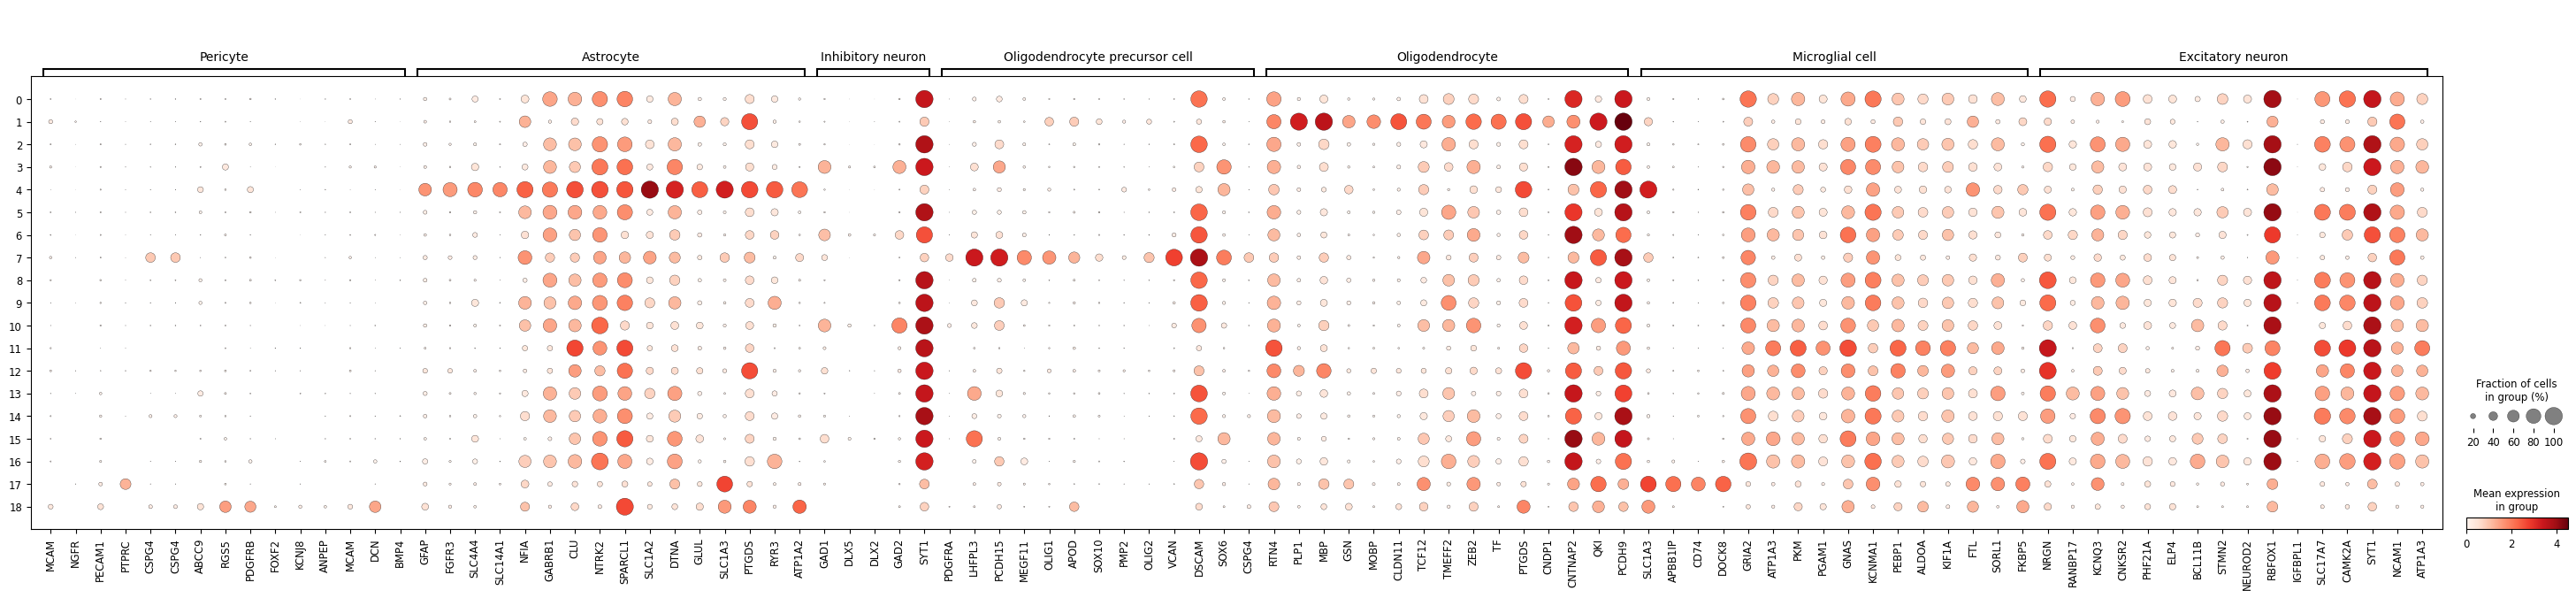

In [21]:
sc.pl.dotplot(adata, cell_marker4disp_dic, groupby='leiden', dendrogram=False, var_group_rotation=0, show=False)
# Save the plot as a PNG file with 600 DPI
plt.savefig('./mean_expr_dotplot.png', dpi=300)

In [ ]:
adata.write_h5ad(
    "./data/7.H5AD_leiden&cell_annotation/scVI_integration_decoupleR_anno_v1.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)